In [1]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append("../pyfortracc/")
import pyfortracc

import xarray as xr
import numpy as np
import glob
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import pathlib

In [2]:
def read_gsmap(path):
    ds=xr.open_dataset(path, engine='netcdf4', decode_times=False)
    ds = ds['hourlyPrecipRate']
    ds=ds.sel(Latitude=slice(-90,90)).data[0]
    ds[ds < 0.1] = np.nan
    return ds

def read_imerg(path):
    ds = xr.open_dataset(path, engine='netcdf4')
    data = ds['precipitation'][0]
    data = np.rot90(data, k=1)
    data[data < 0.1] = np.nan
    return data[::-1]

In [3]:
GSMAP_PATH = '/storage/precipitation/jaxa/v8/2020/01/01/'
IMERG_PATH = '/storage/preciptation/imerg/final_v7/2020/01/01/'

GSMAP_FILES_ = sorted(glob.glob(GSMAP_PATH + '*.nc'))
IMERG_FILES = sorted(glob.glob(IMERG_PATH + '*.nc4'))

# Duplicate GSMAP files to match IMERG files for comparison
GSMAP_FILES = []
for file in GSMAP_FILES_:
    GSMAP_FILES.append(file)
    GSMAP_FILES.append(file)

In [4]:
gsm_data = read_gsmap(GSMAP_FILES[0])
img_data = read_imerg(IMERG_FILES[0])

Text(0.5, 1.0, 'IMERG Final Hourly Precipitation Rate (mm/h) \n2020-01-01 00:00 UTC')

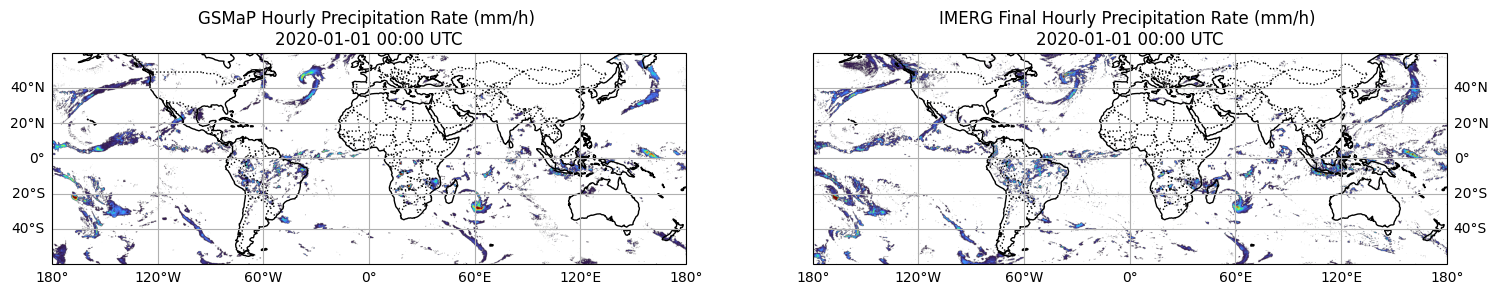

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(18, 12), subplot_kw={'projection': ccrs.PlateCarree()})

extent = [-180, 180, -90, 90]

for ax in axs:
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = False
    if ax == axs[0]:
        gl.right_labels = False
    else:
        gl.left_labels = False
    ax.set_extent(extent)

# # plot gsm_data as imshow
axs[0].imshow(gsm_data, origin='lower',  cmap='turbo', vmin=0, vmax=20, extent=extent)
axs[1].imshow(img_data, origin='lower',  cmap='turbo', vmin=0, vmax=20, extent=extent)

# Set limits
for ax in axs:
    ax.set_ylim(-60, 60)

# Transform name of file to timestamp
timestamp = pd.to_datetime('.'.join(pathlib.Path(GSMAP_FILES[0]).stem.split('.')[1:3]), format='%Y%m%d.%H%M')

axs[0].set_title(f'GSMaP Hourly Precipitation Rate (mm/h) \n{timestamp.strftime("%Y-%m-%d %H:%M UTC")}')
axs[1].set_title(f'IMERG Final Hourly Precipitation Rate (mm/h) \n{timestamp.strftime("%Y-%m-%d %H:%M UTC")}')

In [9]:
import numpy as np, pandas as pd, pathlib, folium
from folium.plugins import DualMap
from matplotlib import cm, colors
from IPython.display import IFrame


extent = [-180,180,-60,60]  # lon_min, lon_max, lat_min, lat_max
lon_min,lon_max,lat_min,lat_max = extent
bounds = [[lat_min,lon_min],[lat_max,lon_max]]

def to_rgba(data,vmin=0,vmax=20,cmap_name='turbo'):
    norm = colors.Normalize(vmin=vmin,vmax=vmax,clip=True)
    cmap = cm.get_cmap(cmap_name)
    rgba = (cmap(norm(data))*255).astype('uint8')
    return np.flipud(rgba)  # folium considera a primeira linha como topo

# gera as imagens coloridas
gsm_rgba  = to_rgba(gsm_data,0,20,'turbo')
imerg_rgba = to_rgba(img_data,0,20,'turbo')

# timestamp como no seu código
ts = pd.to_datetime('.'.join(pathlib.Path(GSMAP_FILES[0]).stem.split('.')[1:3]),format='%Y%m%d.%H%M')
ts_str = ts.strftime('%Y-%m-%d %H:%M UTC')

# mapa dual (dois painéis sincronizados)
center = [(lat_min+lat_max)/2,(lon_min+lon_max)/2]
m = DualMap(location=center,zoom_start=3)

folium.raster_layers.ImageOverlay(gsm_rgba,bounds=bounds,opacity=0.9,interactive=False,
    name=f"GSMaP Hourly Precipitation Rate (mm/h) - {ts_str}").add_to(m.m1)
folium.raster_layers.ImageOverlay(imerg_rgba,bounds=bounds,opacity=0.9,interactive=False,
    name=f"IMERG Final Hourly Precipitation Rate (mm/h) - {ts_str}").add_to(m.m2)

folium.LayerControl(collapsed=False).add_to(m)
# m.save("gsmap_imerg_dualmap.html")

m.save("map.html")
IFrame("map.html", width=1000, height=600)



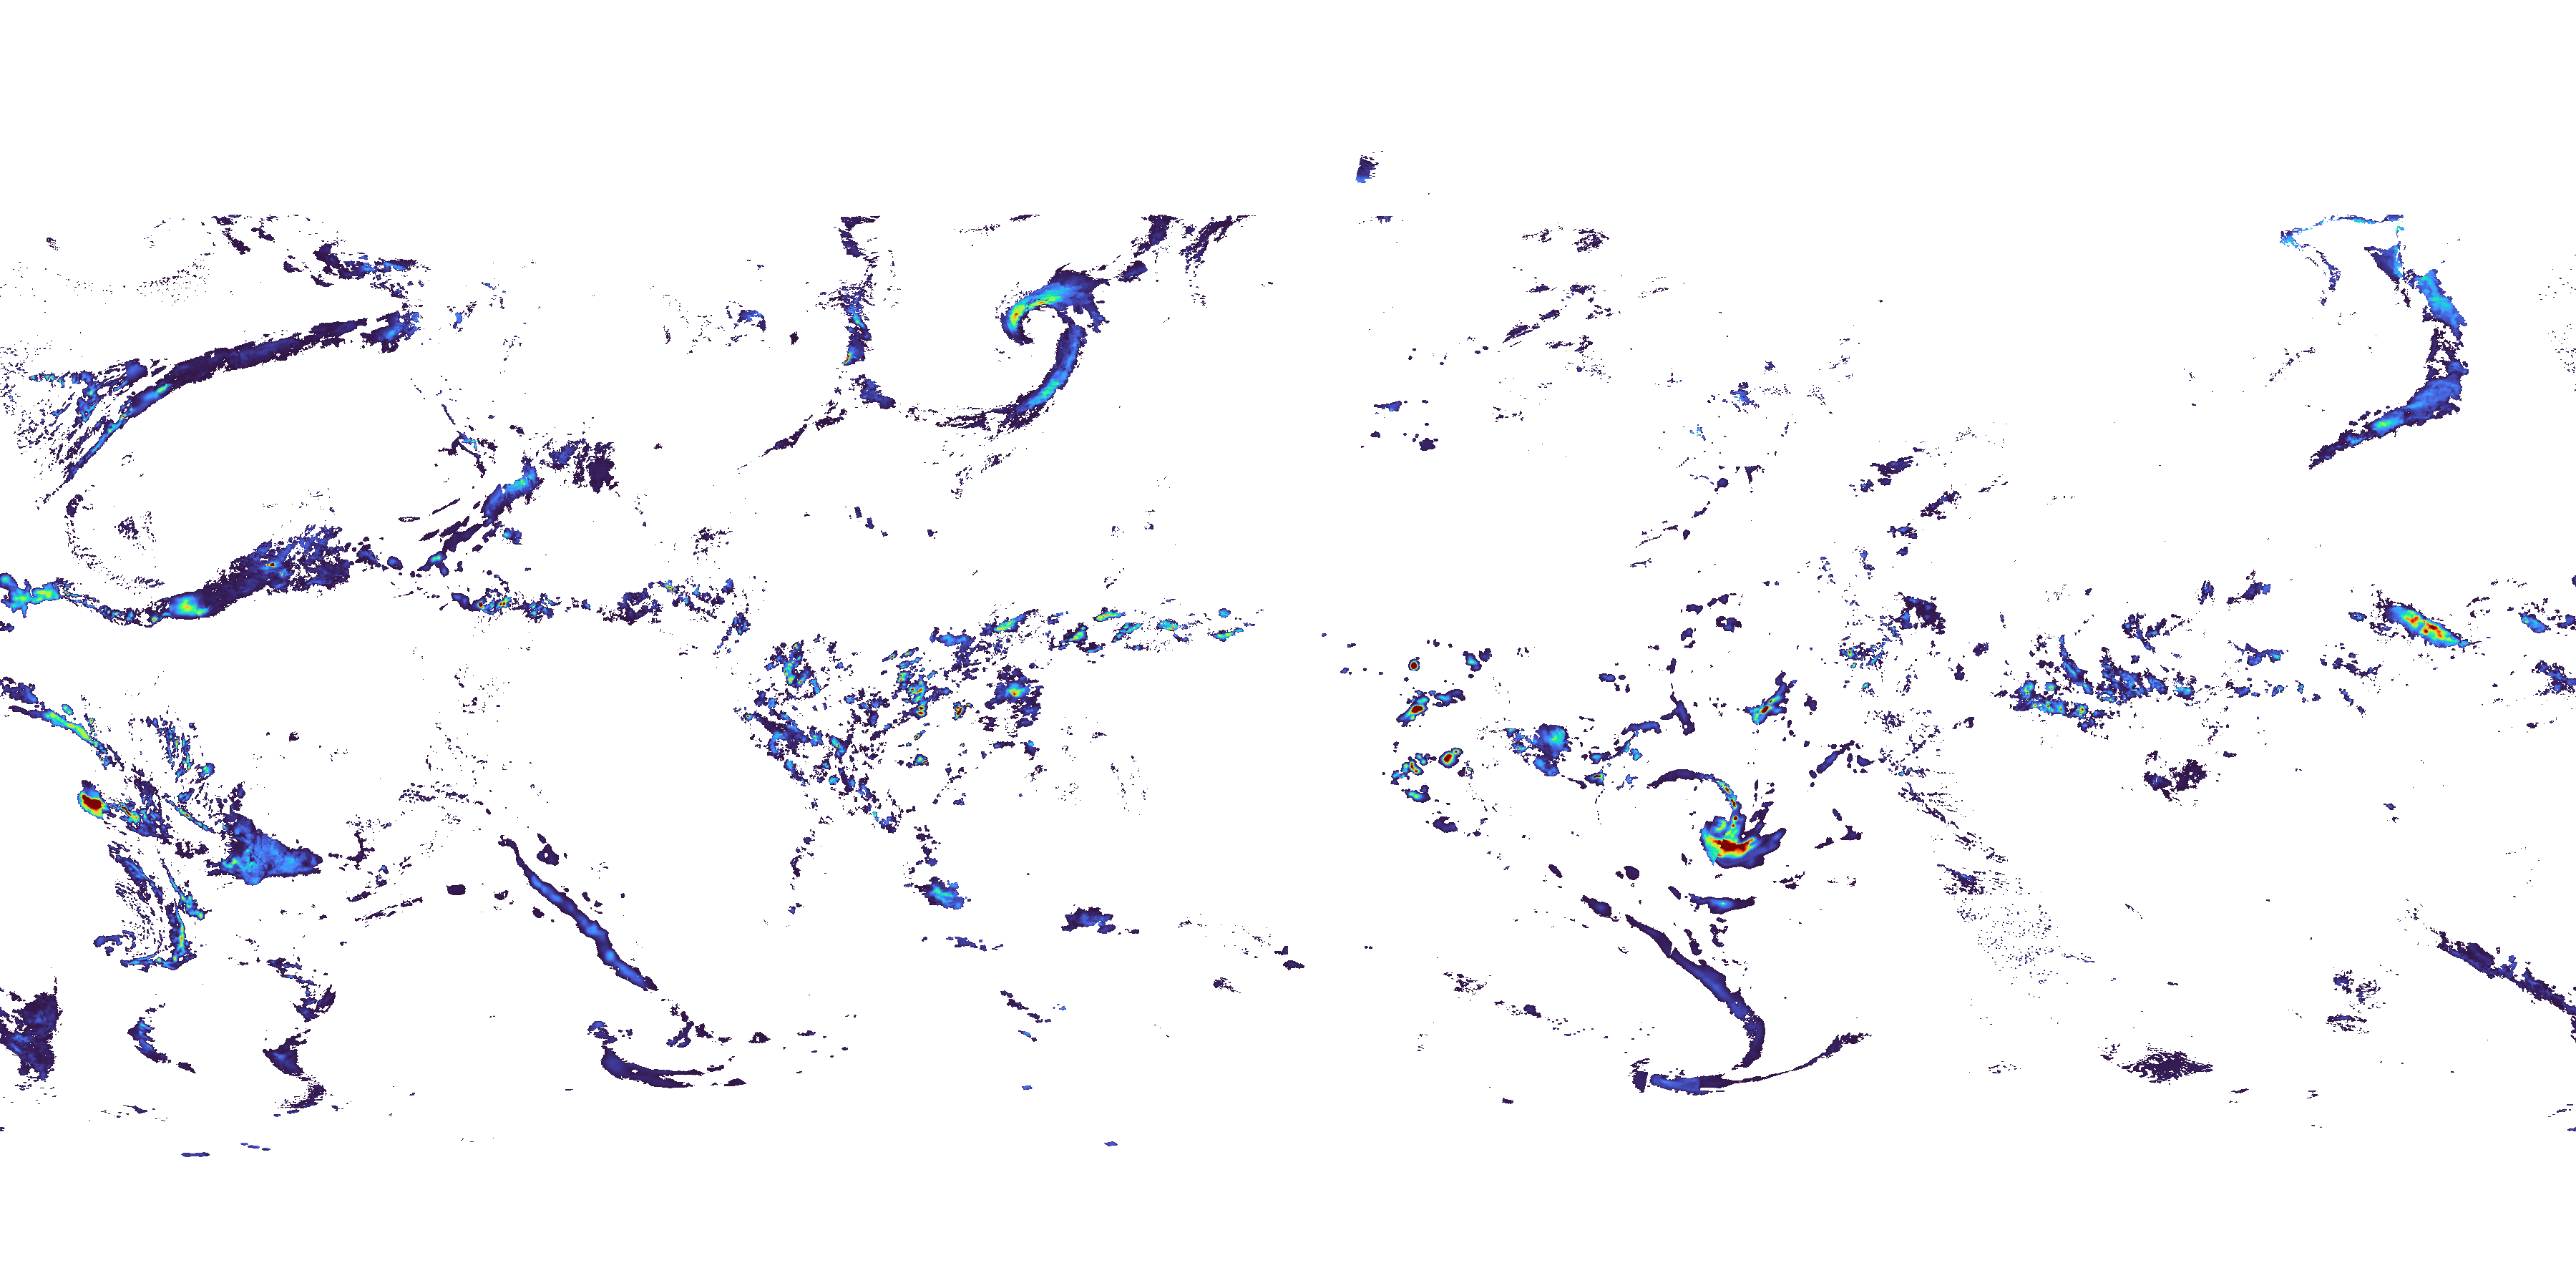
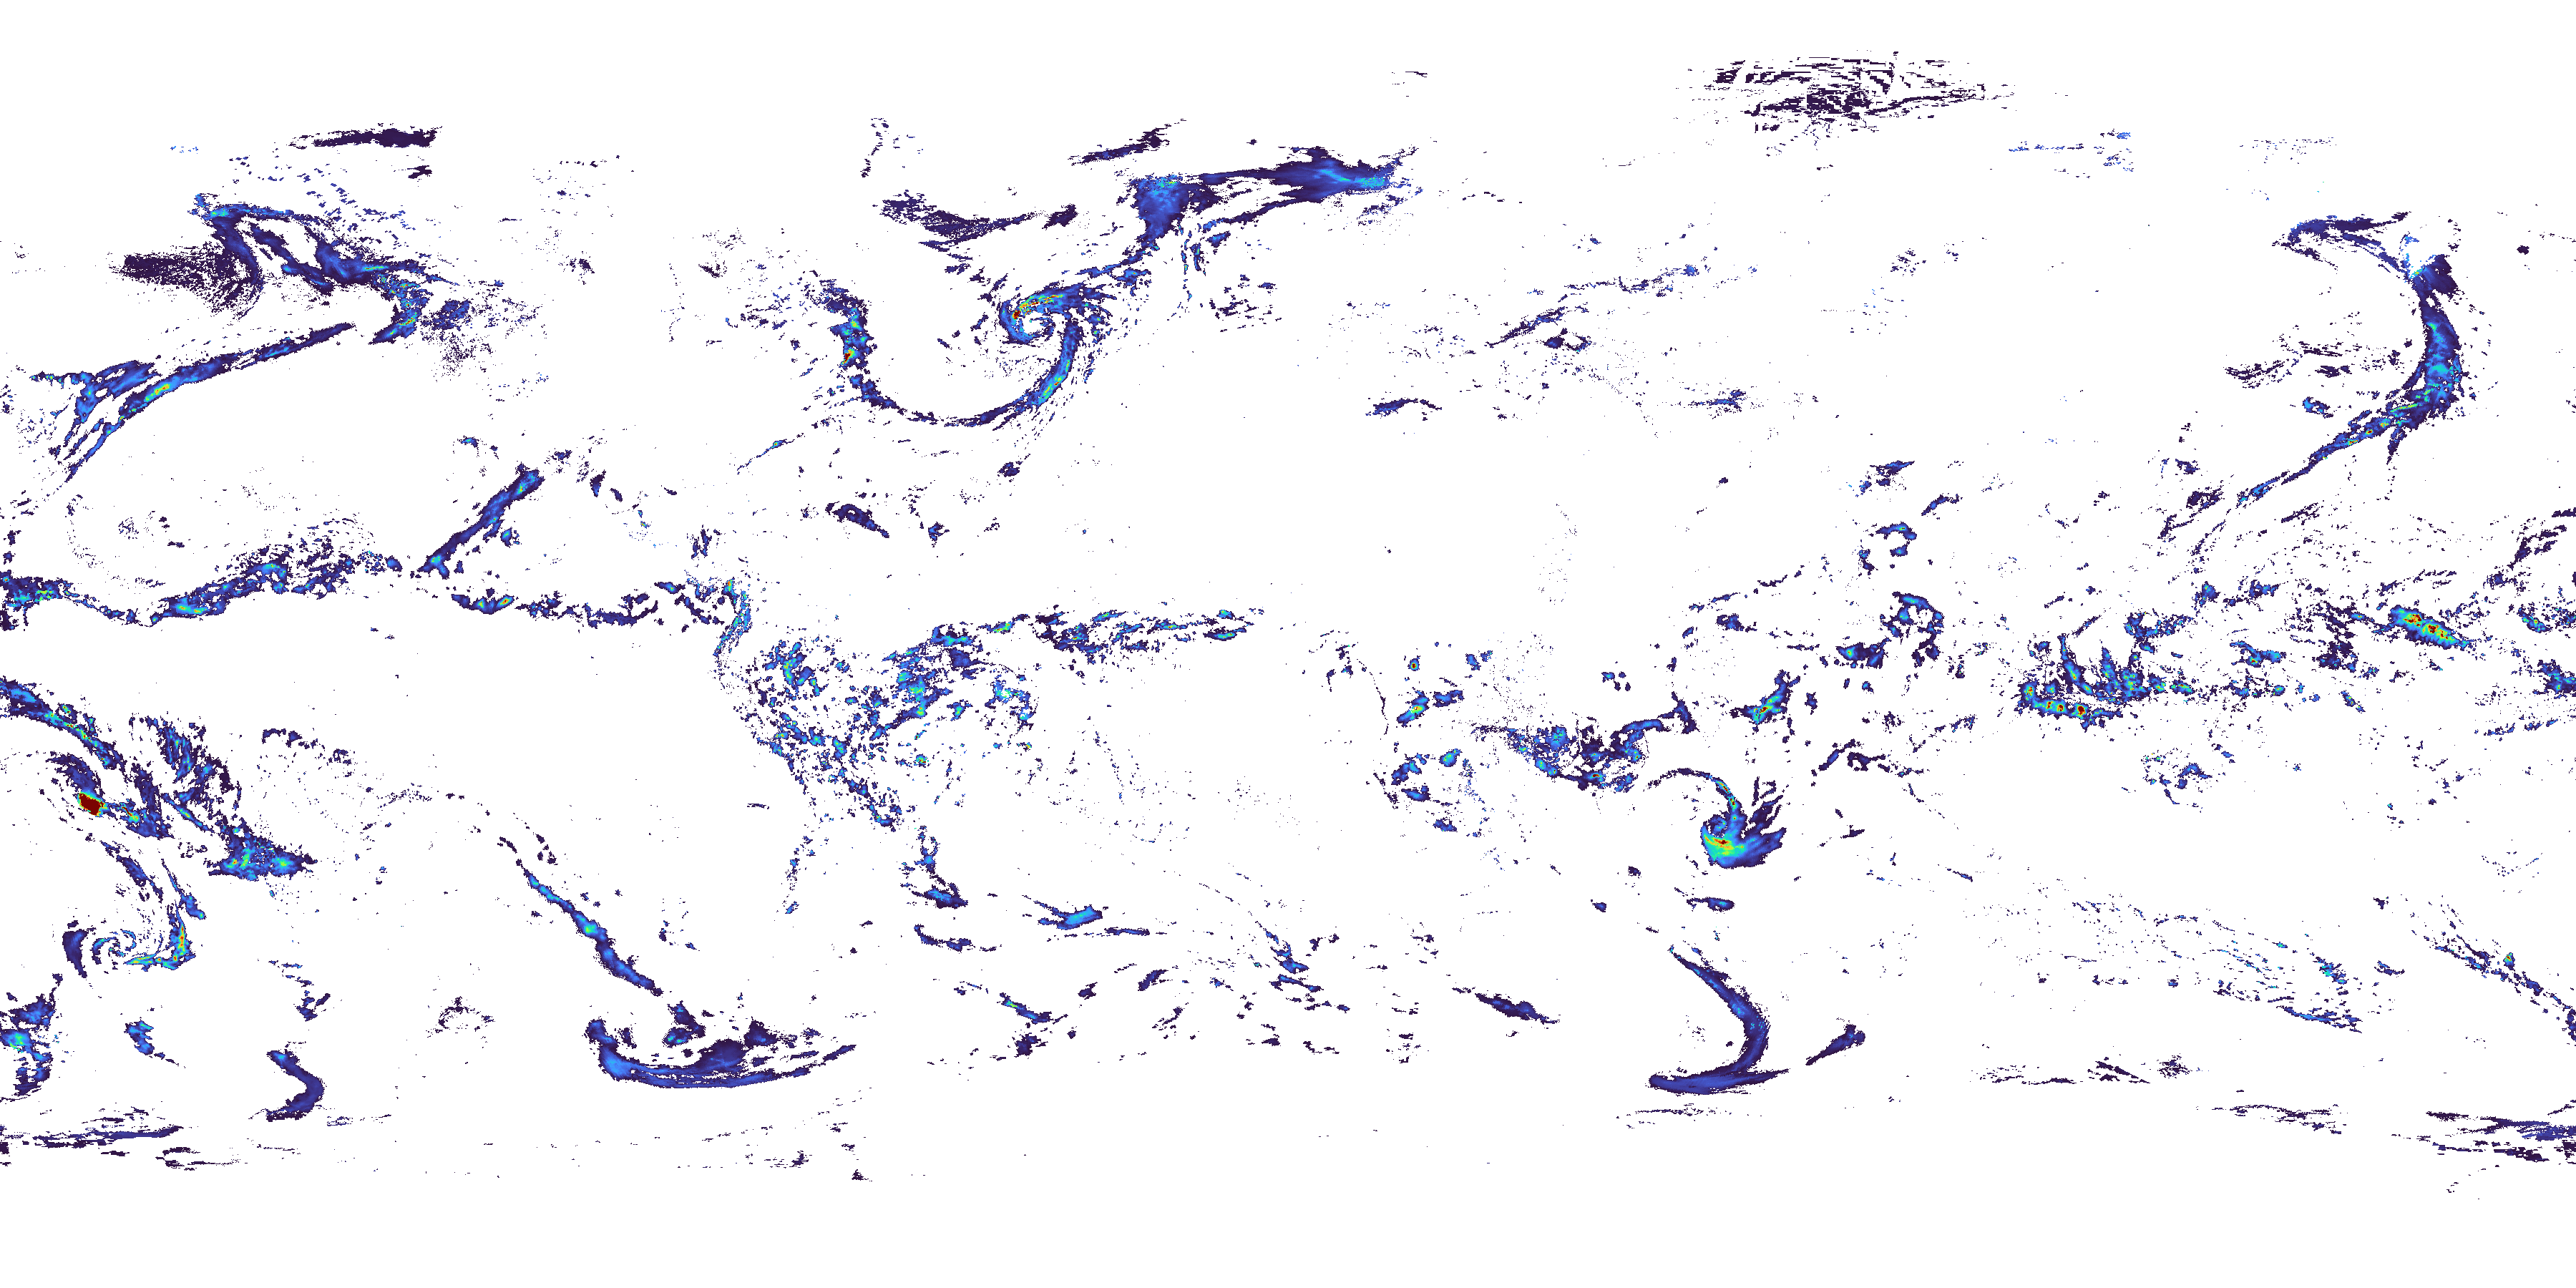

In [7]:
m

In [13]:
import os, matplotlib.pyplot as plt, cartopy.crs as ccrs, cartopy.feature as cfeature
from multiprocessing import Pool, cpu_count
from tqdm import tqdm

def _render_frame(args):
    i,gfile,ifile,global_extent,center,final_size,zoom_frames,vmin,vmax,dpi,outdir = args
    g_lon_min,g_lon_max,g_lat_min,g_lat_max = global_extent
    fw,fh = final_size; cx,cy = center
    # extent final em torno do centro (Belém ou objeto)
    f_lon_min = max(g_lon_min,cx-fw/2); f_lon_max = min(g_lon_max,cx+fw/2)
    f_lat_min = max(g_lat_min,cy-fh/2); f_lat_max = min(g_lat_max,cy+fh/2)
    # fração do zoom (0 = global, 1 = quadro final)
    f = min(1.0, i/float(max(1,zoom_frames)))
    lon_min = g_lon_min + f*(f_lon_min-g_lon_min); lon_max = g_lon_max + f*(f_lon_max-g_lon_max)
    lat_min = g_lat_min + f*(f_lat_min-g_lat_min); lat_max = g_lat_max + f*(f_lat_max-g_lat_max)
    extent = (lon_min,lon_max,lat_min,lat_max)

    gsm_data, img_data = read_gsmap(gfile), read_imerg(ifile)
    proj = ccrs.PlateCarree()
    fig,axs = plt.subplots(1,2,figsize=(12,6),subplot_kw={'projection':proj})

    for j,ax in enumerate(axs):
        ax.coastlines()
        ax.add_feature(cfeature.BORDERS,linestyle=':')
        gl = ax.gridlines(draw_labels=True); gl.top_labels = False
        if j == 0: gl.right_labels = False
        else: gl.left_labels = False
        ax.set_extent(extent,crs=proj)  # AQUI é o zoom cinematográfico

    axs[0].set_title("GSMaP"); axs[1].set_title("IMERG")
    axs[0].imshow(gsm_data,origin='lower',extent=global_extent,transform=proj,cmap='turbo',vmin=vmin,vmax=vmax)
    axs[1].imshow(img_data,origin='lower',extent=global_extent,transform=proj,cmap='turbo',vmin=vmin,vmax=vmax)

    fig.tight_layout()
    os.makedirs(outdir,exist_ok=True)
    out_path = os.path.join(outdir,f"frame_{i:05d}.png")
    fig.savefig(out_path,dpi=dpi,bbox_inches='tight'); plt.close(fig)
    return out_path

def render_cinematic_zoom_frames(GSMAP_FILES,IMERG_FILES,output_dir="frames_zoom",
                                 global_extent=(0,360,-90,60),fixed_center=(311.5,-1.5),
                                 final_width=20,final_height=15,zoom_frames=40,
                                 vmin=0,vmax=20,dpi=150,track_lon=None,track_lat=None,n_workers=None):
    n = min(len(GSMAP_FILES),len(IMERG_FILES))
    if n_workers is None: n_workers = max(1,min(cpu_count()-1,n))
    centers = [(float(track_lon[i]),float(track_lat[i])) if (track_lon is not None and track_lat is not None) else fixed_center for i in range(n)]
    args = [(i,GSMAP_FILES[i],IMERG_FILES[i],global_extent,centers[i],(final_width,final_height),zoom_frames,vmin,vmax,dpi,output_dir) for i in range(n)]
    with Pool(processes=n_workers) as pool:
        for _ in tqdm(pool.imap_unordered(_render_frame,args),total=n,desc="Renderizando frames"): pass
    print("Frames salvos em:",os.path.abspath(output_dir))


In [ ]:
render_cinematic_zoom_frames(
    GSMAP_FILES, IMERG_FILES,
    output_dir="frames_belem_zoom",
    global_extent=(0,360,-90,60),
    fixed_center=(311.5,-1.5),   # centro ~Belém em 0–360
    final_width=18, final_height=14,
    zoom_frames=60,              # quantos frames até completar o zoom
    vmin=0, vmax=20, dpi=150
)

Renderizando frames:  98%|█████████▊| 47/48 [00:59<00:00,  2.89it/s]

In [12]:
ani

NameError: name 'ani' is not defined